**Time Series Analysis: Anomaly Detection**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CV och personligt brev/Exjobb/Gilion 3rd round Interview - Case Interview/data/ambient_temperature_system_failure.csv', sep=',')
df.head(10)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
5,2013-07-04 05:00:00,70.060966
6,2013-07-04 06:00:00,69.279765
7,2013-07-04 07:00:00,69.369608
8,2013-07-04 08:00:00,69.166714
9,2013-07-04 09:00:00,68.986083


In [ ]:
df.tail(10)

,timestamp,value
7257,2014-05-28 06:00:00,64.784023
7258,2014-05-28 07:00:00,65.645874
7259,2014-05-28 08:00:00,67.472568
7260,2014-05-28 09:00:00,68.033080
7261,2014-05-28 10:00:00,70.455717
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226
7266,2014-05-28 15:00:00,72.584089


In [ ]:
# Exclude datetime column
data_values = df.drop('timestamp',
                        axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,
                              columns=df.columns[1:])

# Add back datetime column
data_converted.insert(0, 'timestamp',
                      df['timestamp'])

In [ ]:
data_converted.head(10)

,timestamp,value
0,2013-07-04 00:00:00,69.880836
1,2013-07-04 01:00:00,71.220230
2,2013-07-04 02:00:00,70.877808
3,2013-07-04 03:00:00,68.959396
4,2013-07-04 04:00:00,69.283554
5,2013-07-04 05:00:00,70.060966
6,2013-07-04 06:00:00,69.279762
7,2013-07-04 07:00:00,69.369606
8,2013-07-04 08:00:00,69.166718
9,2013-07-04 09:00:00,68.986084


In [ ]:
data_converted.isna().sum()

,0
timestamp,0
value,0


In [ ]:
# We now want to perform anomaly detection using AutoEncoder
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

In [ ]:
# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3265.9907
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 469.5468
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.0101
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0359
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020
Epoch 13/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 14/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 15/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [ ]:
# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

In [ ]:
anomaly_scores.head(10)

,anomaly_scores
0,0.000186
1,0.000008
2,0.000031
3,0.000446
4,0.000342
5,0.000149
6,0.000343
7,0.000317
8,0.000378
9,0.000437


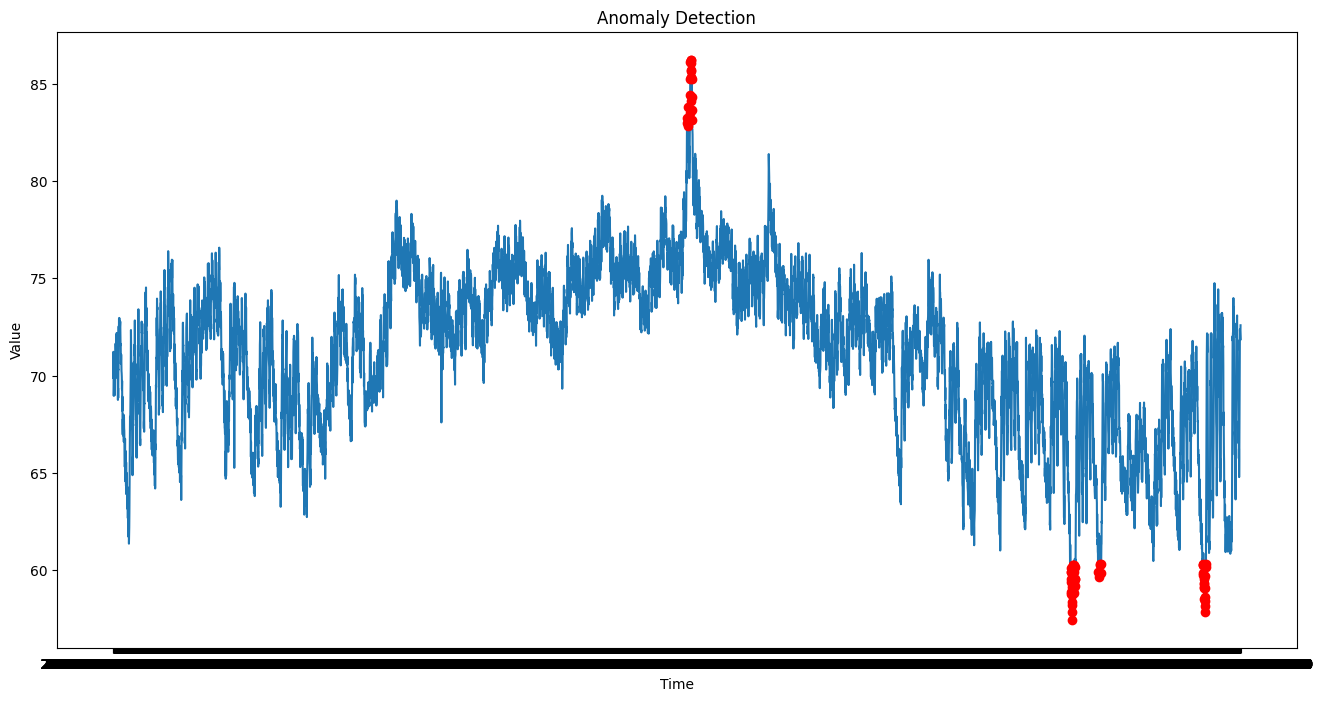

In [ ]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()